In [157]:
import numpy as np
import scipy as sp
import math
from scipy.optimize.slsqp import approx_jacobian
import matplotlib.pyplot as plt

# データ点準備

In [182]:
def stateFunction(x):
        return 0.2*x +  25*x/(1+x**2) + 8*np.cos(1.2 * x) + np.random.normal(loc   = 0,scale = 0.5**2)

In [183]:
def observationFunction(x):
    return np.sin(x/10) + np.random.normal(loc = 0,scale = 0.05**2)

In [184]:
# 学習用データ
t = np.linspace(start=0,stop=50,num=51)
Xt = np.linspace(start=-30,stop=30,num=400)
Xt_1 = np.array([stateFunction(x) for x in Xt])
Y =  np.array([ observationFunction(x) for x in Xt_1])
# Xtt =　[stateFunction(x) for x in Xt]

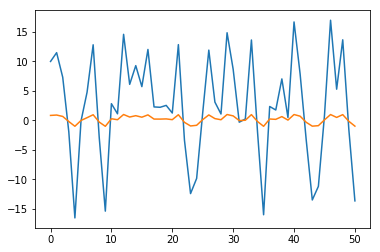

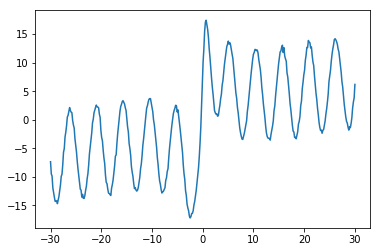

In [193]:
# 実際のデータ
realXt = np.zeros(len(t))
realXt[0]= 10
for i in range(len(t)):
    if i != 0:
        realXt[i] = stateFunction(realXt[i-1])
realYt = np.zeros(len(t))
for i in range(len(t)):
    realYt[i] = observationFunction( realXt[i] )
plt.plot(t,realXt)
plt.plot(t,realYt)
plt.show()
plt.plot(Xt,Xt_1)

# ガウス過程

In [176]:
# https://qiita.com/ctgk/items/4c4607edf15072cddc46
class GaussianKernel(object):
    # カーネル関数のパラメータa,bを初期化
    def __init__(self, params):
        assert np.shape(params) == (2,)
        self.__params = params

    # カーネル関数のパラメータa,bを返す
    def get_params(self):
        return np.copy(self.__params)

     # x,yを入力としてカーネル関数の値を計算 PRML式(6.63)
    def __call__(self, x, y):
        return (self.__params[0])* np.exp(-0.5 * self.__params[1] * (x - y) ** 2)

    # x,yを入力とした時のカーネル関数のパラメータでの微分を計算
    def derivatives(self, x, y):
        sq_diff = (x - y) ** 2
        # パラメータaでの微分
        delta_0 = 2*self.__params[0]*np.exp(-0.5 * self.__params[1] * sq_diff)
        # パラメータbでの微分
        delta_1 = -0.5 * sq_diff * delta_0 * self.__params[0]**2
        return (delta_0, delta_1)

    # カーネル関数のパラメータを更新
    def update_parameters(self, updates):
        assert np.shape(updates) == (2,)
        self.__params += updates

In [201]:
class GaussianProcessRegression(object):
    # カーネル関数とノイズの精度パラメータの初期化
    def __init__(self, kernel, beta=1.):
        self.kernel = kernel
        self.beta = beta #論文ではγ

    # カーネル関数のパラメータ推定を行わずに回帰
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.K = np.zeros([len(x),len(x)])
        for i in range(len(x)):
            for j in range(len(x)):
                self.K[i][j] = self.kernel(x[i],x[j])

    # カーネル関数のパラメータの推定を行う回帰
    def fit_kernel(self, x, t, learning_rate=0.1, iter_max=10000):
        for i in range(iter_max):
            params = self.kernel.get_params()
            # カーネル関数の今のパラメータで回帰
            self.fit(x, t)
            # 対数エビデンス関数をパラメータで微分
            gradients = self.kernel.derivatives(*np.meshgrid(x, x))
            # パラメータの更新量を計算 PRML式(6.70)
            updates = np.array(
                [-np.trace(self.precision.dot(grad)) + t.dot(self.precision.dot(grad).dot(self.precision).dot(t)) for grad in gradients])
            # パラメータを更新
            self.kernel.update_parameters(learning_rate * updates)
            # パラメータの更新量が小さければ更新をやめる
            
            if np.allclose(params, self.kernel.get_params()):
                break
        else:
            # 既定の更新回数だけ更新してもパラメータの更新量が小さくない場合以下の文を出力
            print("parameters may not have converged")
            
    def kernels(self,x):
        return np.array([self.kernel(x,_x) for _x in Xt]).T
    
    def kernels_dif(self,x):
        params = self.kernel.get_params()
        return np.array([- params[1]*(self.x[i]-x)*params[0]**2 *np.exp(-0.5.params[1]*(self.x[i]-x)**2)]).T
    
    # 予測分布を出力
    def predict_dist(self, x):
        K = self.kernel(*np.meshgrid(x, self.x, indexing='ij'))
        # 予測分布の平均を計算 PRML式(6.66)
        mean = K.dot(self.precision).dot(self.t)
        # 予測分布の分散を計算 PRML式(6.67)
        var = self.kernel(x, x) + 1 / self.beta - np.sum(K.dot(self.precision) * K, axis=1)
        return mean.ravel(), np.sqrt(var.ravel())
    
    def mean(self,x):
        return self.kernels(x).T.dot(np.linalg.inv(self.K + self.beta*np.eye(len(self.x)))).dot(self.y)
    
    def mean_j(self,x):
        return self.kernels_dif(x).T.dot(np.linalg.inv(self.K + self.beta*np.eye(len(x)) )).dot(y)
    
    def var(self,x):
        return self.kernel(x,x)- self.kernels(x).T.dot((np.linalg.inv(self.K)).dot(kernels(x)))

-30.0 -7.34614248671 5.14495962925e-45
6.44770433905


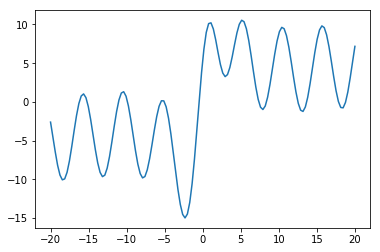

In [203]:

stateKernel = GaussianKernel(params=np.array([1.937, 0.4]))
# print(vars(stateKernel))
print(Xt[0],Xt_1[0],stateKernel(Xt[0],Xt_1[0]))
stateRegression = GaussianProcessRegression(kernel=stateKernel, beta=4.0)
stateRegression.fit(Xt,Xt_1)
stateMean = stateRegression.mean
statevar = stateRegression.var
print(stateMean(2))
test_x = np.linspace(start=-20,stop=20,num=130)
test_y = [stateMean(x) for x in test_x]
plt.plot(test_x,test_y)
# plt.scatter(x, t, alpha=0.5, color="blue", label="observation")
# plt.plot(x_test, func(x_test), color="blue", label="sin$(2\pi x)$")
# plt.plot(x_test, y, color="red", label="predict_mean")
# plt.fill_between(x_test, y - y_std, y + y_std, color="pink", alpha=0.5, label="predict_std")
# plt.legend(loc="lower left")
# plt.show()
# print(vars(stateRegression))

In [172]:
assumeXt = np.zeros(len(t))
assumeXt[0]= 10
for i in range(len(t)):
    if i != 0:
        assumeXt[i] = stateMean(assumeXt[i-1])

print(assumeXt)

[  1.00000000e+01  -1.36751627e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00   6.44714782e+04
   0.00000000e+00   6.44714782e+04   0.00000000e+00]


In [17]:
def create_toy_data(func, low=0, high=1., n=10, std=1.):
    x = np.random.uniform(low, high, n)
    t = func(x) + np.random.normal(scale=std, size=n)
    return x, t

In [31]:
def main():
    # 学習データが従う関数を設定
    # 学習データを生成
#     x, t = create_toy_data(func, high=0.7, std=0.1)

    # カーネル関数の設定、パラメータはてきとうに設定
    kernel = GaussianKernel(params=np.array([1., 1.]))
    # ガウス過程回帰に用いるカーネル関数と精度パラメータ(真の値)の設定
    regression = GaussianProcessRegression(kernel=kernel, beta=100)
    # カーネル関数のパラメータの推定も含めた回帰、regression.fit(x,t)に替えるとパラメータを推定せず回帰
    regression.fit_kernel(x, t, learning_rate=0.1, iter_max=10000)

    # テストデータについて予測分布を出力
    x_test = np.linspace(0, 1, 100)
    y, y_std = regression.predict_dist(x_test)

    # 回帰の結果をプロット
    plt.scatter(x, t, alpha=0.5, color="blue", label="observation")
    plt.plot(x_test, func(x_test), color="blue", label="sin$(2\pi x)$")
    plt.plot(x_test, y, color="red", label="predict_mean")
    plt.fill_between(x_test, y - y_std, y + y_std, color="pink", alpha=0.5, label="predict_std")
    plt.legend(loc="lower left")
    plt.show()
    return kernel

In [189]:
# kernel = GaussianKernel(params=np.array([1.937, 0.4]))
# stateRegression = GaussianProcessRegression(kernel=kernel, beta=1)
# params = kernel.get_params()
# stateK = np.zeros([len(Xt),len(Xt)])
# for i in range(len(Xt)):
#     for j in range(len(Xt)):
#         stateK[i][j] = kernel(Xt[i],Xt[j])
# def stateKernels(x):
#     return np.array([ kernel(x,_x) for _x in Xt])
# stateRegression.fit_kernel(Xt, Xt_1, learning_rate=0.0001, iter_max=100)

In [129]:
def stateMean(x):
    return  stateKernels(x).T*np.linalg.inv(stateK).Xt_1

In [142]:
# reggressionXt, reggressionX_std = stateRegression.predict_dist(t)
# plt.scatter(t, reggressionXt, alpha=0.5, color="blue", label="observation")
# plt.plot(t, stateFunction(t), color="blue", label="sin$(2\pi x)$")
# plt.plot(x_test, y, color="red", label="predict_mean")

# def reggressedStateFunction(x):
    
#     return 

In [139]:
stateKernel = GaussianKernel(params=np.array([1.937, 0.4]))
stateRegression = GaussianProcessRegression(kernel=kernel, beta=1)

In [140]:
stateRegression.fit(Xt,Xt_1)
plt.scatter(x, t, alpha=0.5, color="blue", label="observation")
plt.plot(x_test, func(x_test), color="blue", label="sin$(2\pi x)$")
plt.plot(x_test, y, color="red", label="predict_mean")
plt.fill_between(x_test, y - y_std, y + y_std, color="pink", alpha=0.5, label="predict_std")
plt.legend(loc="lower left")
plt.show()

In [141]:
print(vars(stateRegression))

{'kernel': <__main__.GaussianKernel object at 0x1014bd54e0>, 'beta': 1, 'x': array([-30.        , -29.84962406, -29.69924812, -29.54887218,
       -29.39849624, -29.2481203 , -29.09774436, -28.94736842,
       -28.79699248, -28.64661654, -28.4962406 , -28.34586466,
       -28.19548872, -28.04511278, -27.89473684, -27.7443609 ,
       -27.59398496, -27.44360902, -27.29323308, -27.14285714,
       -26.9924812 , -26.84210526, -26.69172932, -26.54135338,
       -26.39097744, -26.2406015 , -26.09022556, -25.93984962,
       -25.78947368, -25.63909774, -25.4887218 , -25.33834586,
       -25.18796992, -25.03759398, -24.88721805, -24.73684211,
       -24.58646617, -24.43609023, -24.28571429, -24.13533835,
       -23.98496241, -23.83458647, -23.68421053, -23.53383459,
       -23.38345865, -23.23308271, -23.08270677, -22.93233083,
       -22.78195489, -22.63157895, -22.48120301, -22.33082707,
       -22.18045113, -22.03007519, -21.87969925, -21.72932331,
       -21.57894737, -21.42857143, -21.27

In [ ]:
https://qiita.com/ctgk/items/4c4607edf15072cddc46

## EKF

In [27]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# https://satomacoto.blogspot.com/2011/06/python_22.htm

class ekf():
    # 初期化
    T = t # 観測数
    x = 0 # 初期位置
    X = np.mat([0])# 状態
    Y = np.mat([0])# 観測
 
    # state x = A * x_ + B * u + w, w~N(0,Q)
#     A = np.mat([[1,0],[0,1]])
#     B = np.mat([[1,0],[0,1]])
#     u = np.mat([[2],[2]])
#     Q = np.mat([[1,0],[0,1]])
    # observation Y = h(x) + v, v~N(0,R)
#     R = np.mat([[2,0,0],[0,2,0],[0,0,2]])

     
    # EKF
    mu = np.mat([[0],[0]])
    Sigma = np.mat([[0,0],[0,0]])    
    M = [mu] # 推定
    for i in range(T):
        # prediction
        mu = stateMean(x)
        Sigma
        mu_ = A * mu + B * u
        Sigma_ = Q + A * Sigma * A.T
        # update
        #C = Jh0(mu_) # 解析的
        C = Jh1(mu_) # 数値的
        yi = Y[i+1] - C * mu_
        S = C * Sigma_ * C.T + R
        K = Sigma_ * C.T * S.I
        mu = mu_ + K * yi
        Sigma = Sigma_ - K * C * Sigma_
        M.append(mu)
 
    # 描画
    a,b = np.array(np.concatenate(X,axis=1))
    plt.plot(a,b,'rs-')
    a,b = np.array(np.concatenate(M,axis=1))
    plt.plot(a,b,'bo-')
    plt.axis('equal')
    plt.show()


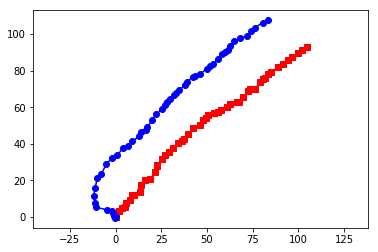

In [28]:
ekf()